In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
spark = SparkSession.builder.master("local[2]").appName("ml").getOrCreate()
sc = spark.sparkContext

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/p2837170titanic/TitanicData.csv
/kaggle/input/titanicdata/TitanicData.csv


In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("TitanicClassification").getOrCreate()

titanic_datatask = spark.read.csv("/kaggle/input/titanicdata/TitanicData.csv",inferSchema=True, header = True)

In [4]:
# Data cleaning: Drop irrelevant columns and handle missing values
# Drop columns that are not useful for prediction
columns_to_drop = ["PassengerId", "Name", "Ticket", "Cabin"]
titanic_datatask = titanic_datatask.drop(*columns_to_drop)

In [5]:
titanic_datatask.show()
# check data type
print(titanic_datatask.printSchema()) 

+------+------+----+-----+-----+-------+--------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Survived|
+------+------+----+-----+-----+-------+--------+--------+
|     3|  male|22.0|    1|    0|   7.25|       S|       0|
|     1|female|38.0|    1|    0|71.2833|       C|       1|
|     3|female|26.0|    0|    0|  7.925|       S|       1|
|     1|female|35.0|    1|    0|   53.1|       S|       1|
|     3|  male|35.0|    0|    0|   8.05|       S|       0|
|     3|  male|NULL|    0|    0| 8.4583|       Q|       0|
|     1|  male|54.0|    0|    0|51.8625|       S|       0|
|     3|  male| 2.0|    3|    1| 21.075|       S|       0|
|     3|female|27.0|    0|    2|11.1333|       S|       1|
|     2|female|14.0|    1|    0|30.0708|       C|       1|
|     3|female| 4.0|    1|    1|   16.7|       S|       1|
|     1|female|58.0|    0|    0|  26.55|       S|       1|
|     3|  male|20.0|    0|    0|   8.05|       S|       0|
|     3|  male|39.0|    1|    5| 31.275|       S|       

In [6]:
# Handle missing values: Fill NA for Age with the average, drop rows with missing Embarked
avg_age = titanic_datatask.select(mean(col("Age"))).first()[0]
titanic_datatask = titanic_datatask.fillna({"Age": avg_age})
titanic_datatask = titanic_datatask.na.drop(subset=["Embarked"])

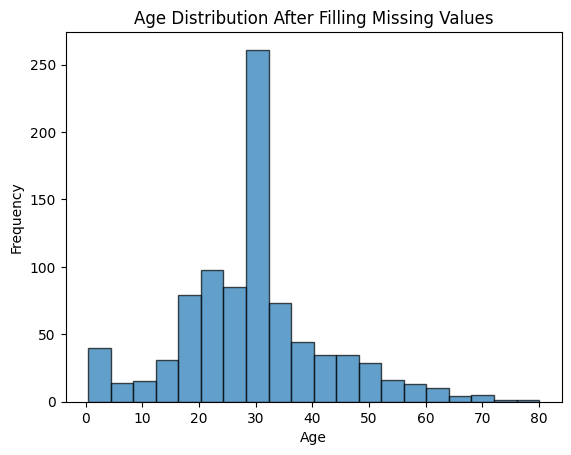

In [7]:
# Visualize Age Distribution
ages = [row["Age"] for row in titanic_datatask.select("Age").collect()]
plt.hist(ages, bins=20, edgecolor='k', alpha=0.7)
plt.title("Age Distribution After Filling Missing Values")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Convert categorical columns to numeric
indexers = [
    StringIndexer(inputCol="Sex", outputCol="SexIndex"),
    StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
]

In [9]:

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"],
    outputCol="features"
)

In [10]:

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

In [11]:
# Prepare data for classification
pipeline = Pipeline(stages=indexers + [assembler, scaler])
titanic_datatask = pipeline.fit(titanic_datatask).transform(titanic_datatask)
pre_titanic_data = titanic_datatask.select(col("scaledFeatures").alias("features"), col("Survived").alias("label"))
# Split the data into training and testing sets
train_data, test_data = pre_titanic_data.randomSplit([0.7, 0.3], seed=42)

In [12]:
pre_titanic_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.59410662015210...|    0|
|[1.19803554005070...|    1|
|[3.59410662015210...|    1|
|[1.19803554005070...|    1|
|(7,[0,1,4],[3.594...|    0|
|[3.59410662015210...|    0|
|(7,[0,1,4],[1.198...|    0|
|[3.59410662015210...|    0|
|[3.59410662015210...|    1|
|[2.39607108010140...|    1|
|[3.59410662015210...|    1|
|[1.19803554005070...|    1|
|(7,[0,1,4],[3.594...|    0|
|[3.59410662015210...|    0|
|[3.59410662015210...|    0|
|[2.39607108010140...|    1|
|[3.59410662015210...|    0|
|(7,[0,1,4],[2.396...|    1|
|[3.59410662015210...|    0|
|[3.59410662015210...|    1|
+--------------------+-----+
only showing top 20 rows



In [13]:
print("Initial Training Data:")
train_data.show(5)
print("Initial Testing Data:")
test_data.show(5)

Initial Training Data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
+--------------------+-----+
only showing top 5 rows

Initial Testing Data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[3.59410...|    0|
+--------------------+-----+
only showing top 5 rows



In [14]:
# Split the data into training and testing sets
train_data, test_data = pre_titanic_data.randomSplit([0.7, 0.3], seed=77)




In [15]:
print("Initial Training Data:")
train_data.show(5)
print("Initial Testing Data:")
test_data.show(5)

Initial Training Data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
+--------------------+-----+
only showing top 5 rows

Initial Testing Data:
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,1],[1.19803...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1],[2.39607...|    0|
|(7,[0,1,4],[1.198...|    1|
+--------------------+-----+
only showing top 5 rows



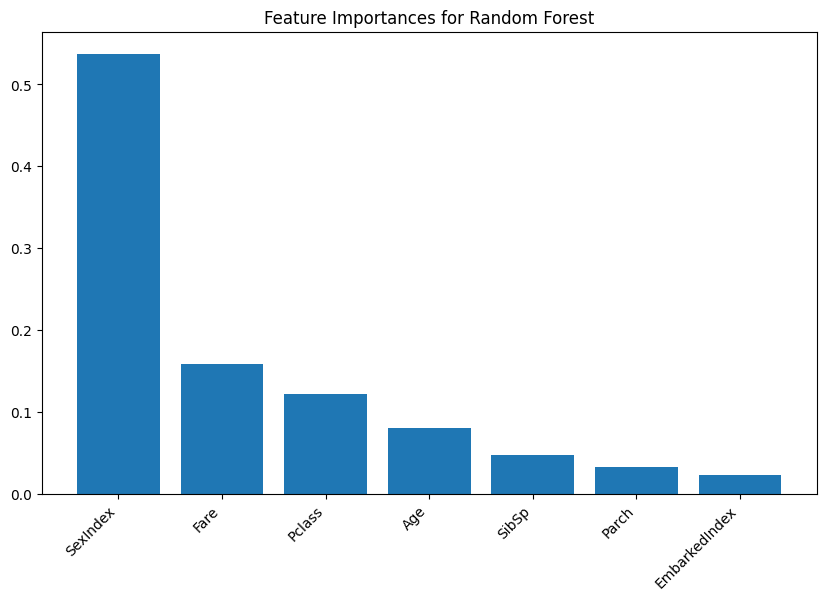

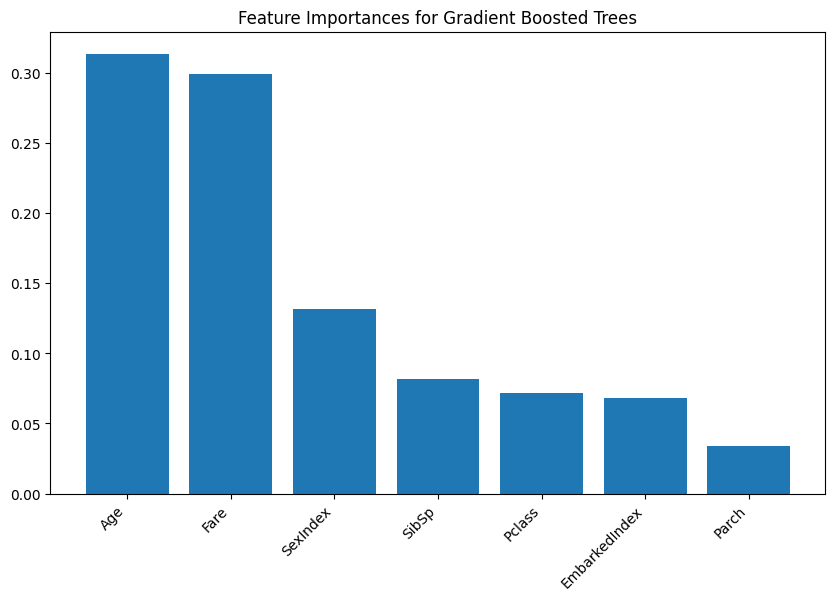

In [16]:
# Define a function to plot feature importances
def plot_feature_importances(importances, feature_names, model_name):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importances)[::-1]
    sorted_importances = np.array(importances)[indices]
    sorted_features = np.array(feature_names)[indices]

    plt.bar(range(len(importances)), sorted_importances, align="center")
    plt.xticks(range(len(importances)), sorted_features, rotation=45, ha="right")
    plt.title(f"Feature Importances for {model_name}")
    plt.show()

# Random Forest Classifier
classifier_rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model_rf = classifier_rf.fit(train_data)

# Visualize Random Forest feature importances
rf_importances = model_rf.featureImportances.toArray()
feature_names = ["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"]
plot_feature_importances(rf_importances, feature_names, "Random Forest")

# Gradient Boosted Trees Classifier
classifier_gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
model_gbt = classifier_gbt.fit(train_data)

# Visualize Gradient Boosted Trees feature importances
gbt_importances = model_gbt.featureImportances.toArray()
plot_feature_importances(gbt_importances, feature_names, "Gradient Boosted Trees")


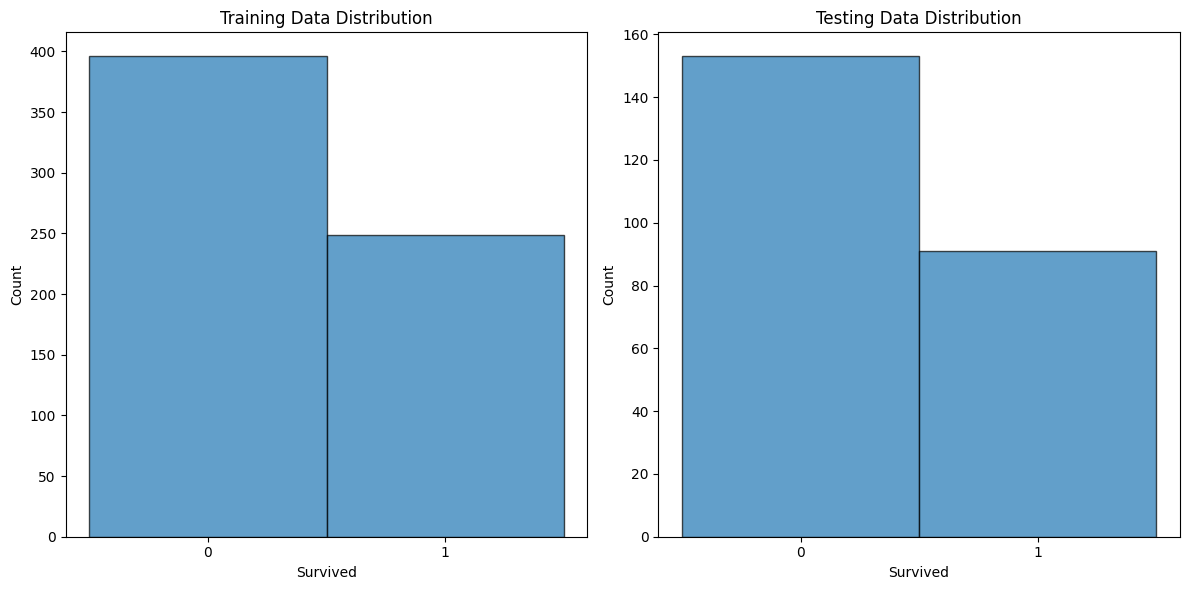

In [17]:
# Visualize the train and test data distribution
train_labels = train_data.select("label").toPandas()["label"].values
test_labels = test_data.select("label").toPandas()["label"].values

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.title("Training Data Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(test_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', alpha=0.7)
plt.xticks([0, 1])
plt.title("Testing Data Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

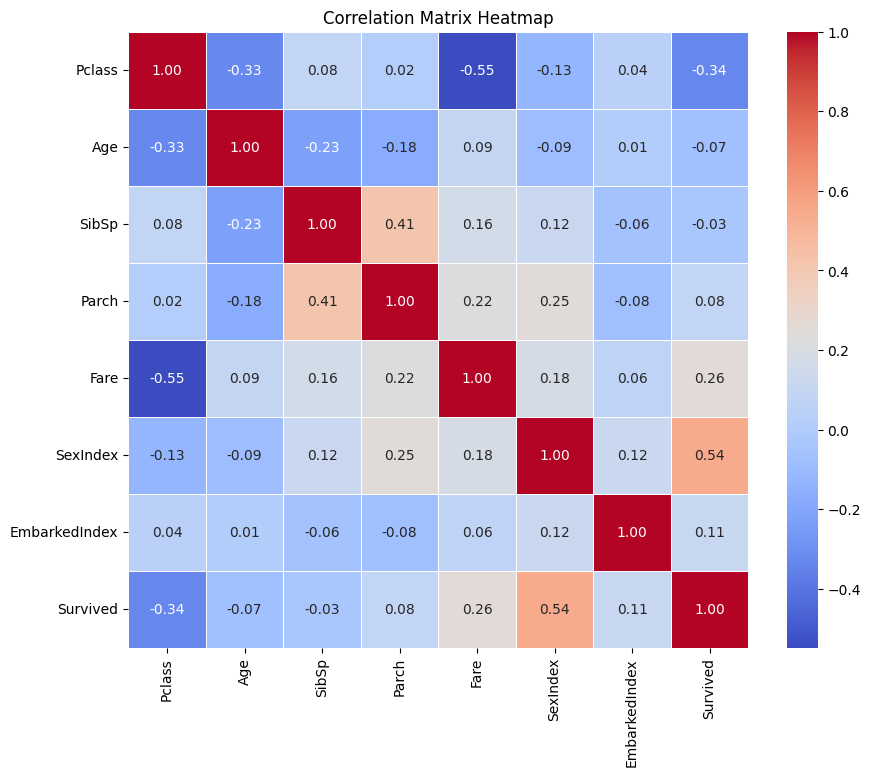

In [18]:
# Create a heatmap of the correlation matrix
# Convert the Spark DataFrame to Pandas DataFrame for visualization
cor_titanic_datatask = titanic_datatask.select(["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex", "Survived"]).toPandas()
correlation_matrix = cor_titanic_datatask.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [19]:
 # Define a function to evaluate the model and plot confusion matrix
def evaluate_model(test_results, model_name):
    evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability")

    accuracy = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "accuracy"})
    precision = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "weightedRecall"})
    f1 = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "f1"})
    auc_roc = evaluator_binary.evaluate(test_results)

    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC-ROC: {auc_roc:.2f}")

    # Confusion Matrix
    y_true = test_results.select("label").toPandas()["label"].values
    y_pred = test_results.select("prediction").toPandas()["prediction"].values
    
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


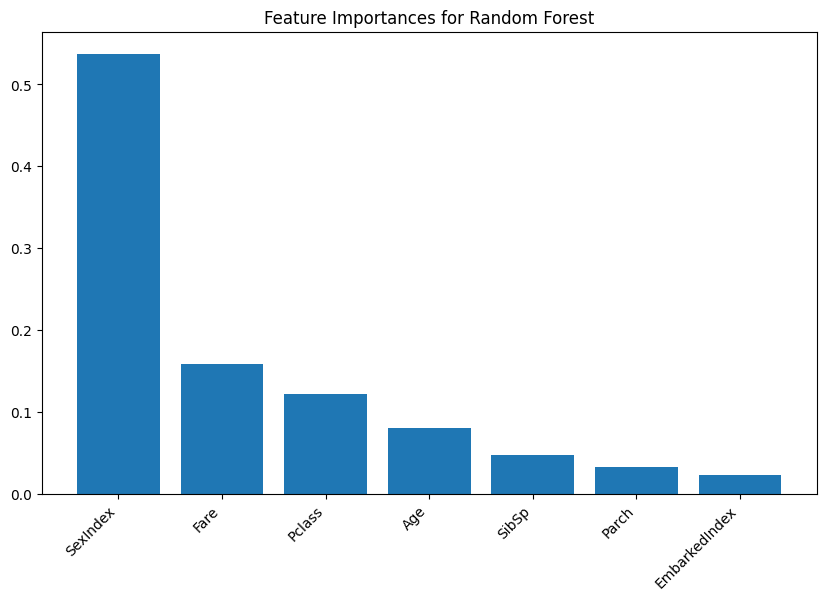

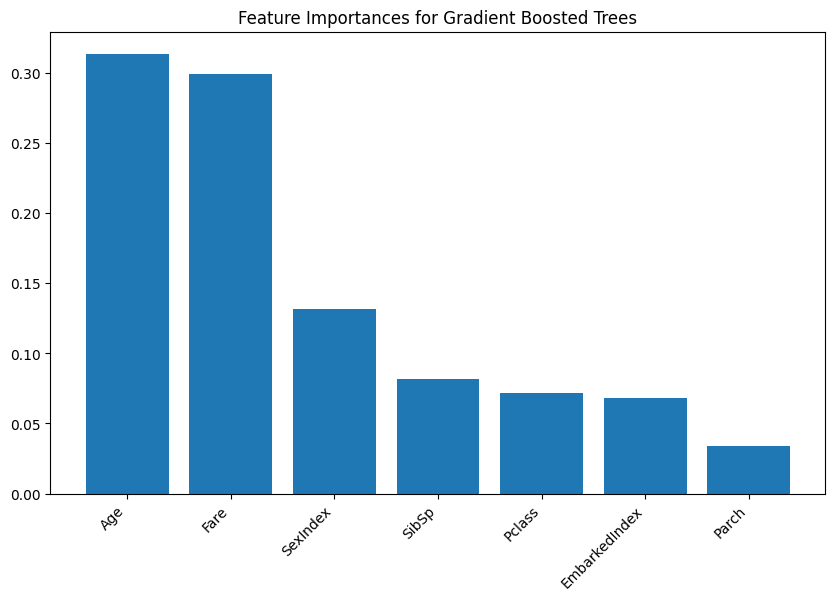

In [20]:
# Define a function to plot feature importances
def plot_feature_importances(importances, feature_names, model_name):
    plt.figure(figsize=(10, 6))
    indices = np.argsort(importances)[::-1]
    sorted_importances = np.array(importances)[indices]
    sorted_features = np.array(feature_names)[indices]

    plt.bar(range(len(importances)), sorted_importances, align="center")
    plt.xticks(range(len(importances)), sorted_features, rotation=45, ha="right")
    plt.title(f"Feature Importances for {model_name}")
    plt.show()

# Random Forest Classifier
classifier_rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model_rf = classifier_rf.fit(train_data)

# Visualize Random Forest feature importances
rf_importances = model_rf.featureImportances.toArray()
feature_names = ["Pclass", "Age", "SibSp", "Parch", "Fare", "SexIndex", "EmbarkedIndex"]
plot_feature_importances(rf_importances, feature_names, "Random Forest")

# Gradient Boosted Trees Classifier
classifier_gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
model_gbt = classifier_gbt.fit(train_data)

# Visualize Gradient Boosted Trees feature importances
gbt_importances = model_gbt.featureImportances.toArray()
plot_feature_importances(gbt_importances, feature_names, "Gradient Boosted Trees")


In [21]:
# Define a function to show predictions
def show_predictions(model, titanicdatatask, dataset_name):
    predictions = model.transform(titanicdatatask)
    print(f"\nPredictions on {dataset_name} Dataset:")
    predictions.select("label", "prediction", "probability").show(10, truncate=False)
    return predictions.select("label", "prediction").toPandas()


Predictions on Training (Random Forest) Dataset:
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.8465025465993834,0.1534974534006166] |
|0    |0.0       |[0.8448679312147681,0.155132068785232]  |
|0    |0.0       |[0.8425952039420408,0.15740479605795923]|
|0    |0.0       |[0.8425952039420408,0.15740479605795923]|
|0    |0.0       |[0.8953766149080691,0.10462338509193089]|
|0    |0.0       |[0.8953766149080691,0.10462338509193089]|
|0    |0.0       |[0.8953766149080691,0.10462338509193089]|
|0    |0.0       |[0.8830079775337165,0.11699202246628353]|
|1    |0.0       |[0.8730079775337165,0.12699202246628352]|
|0    |0.0       |[0.9006667707700212,0.09933322922997882]|
+-----+----------+----------------------------------------+
only showing top 10 rows


Predictions on Testing (Random Forest) Dataset:
+-----+----------+-----------------

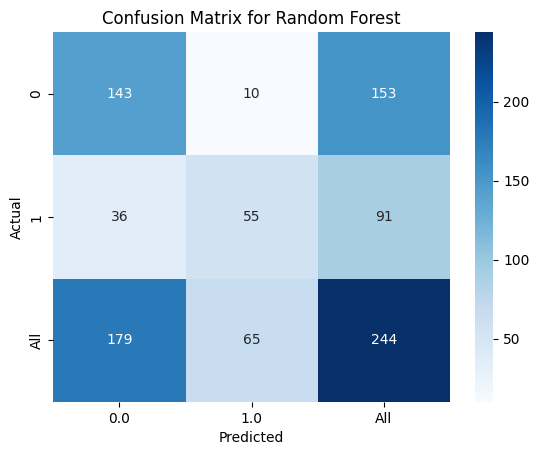

In [22]:
# Apply a classification model (Random Forest)
classifier_rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model_rf = classifier_rf.fit(train_data)
show_predictions(model_rf, train_data, "Training (Random Forest)")
show_predictions(model_rf, test_data, "Testing (Random Forest)")
test_results_rf = model_rf.transform(test_data)
evaluate_model(test_results_rf, "Random Forest")


Predictions on Training (Gradient Boosted Trees) Dataset:
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.9044977268811694,0.09550227311883064]|
|0    |0.0       |[0.927778336874286,0.07222166312571399] |
|0    |0.0       |[0.9236830654725745,0.0763169345274255] |
|0    |0.0       |[0.9236830654725745,0.0763169345274255] |
|0    |0.0       |[0.9454566044961189,0.0545433955038811] |
|0    |0.0       |[0.9454566044961189,0.0545433955038811] |
|0    |0.0       |[0.9454566044961189,0.0545433955038811] |
|0    |0.0       |[0.9437925755565122,0.05620742444348781]|
|1    |1.0       |[0.3370912868503379,0.662908713149662]  |
|0    |0.0       |[0.9695888505754003,0.03041114942459966]|
+-----+----------+----------------------------------------+
only showing top 10 rows


Predictions on Testing (Gradient Boosted Trees) Dataset:
+-----+----------

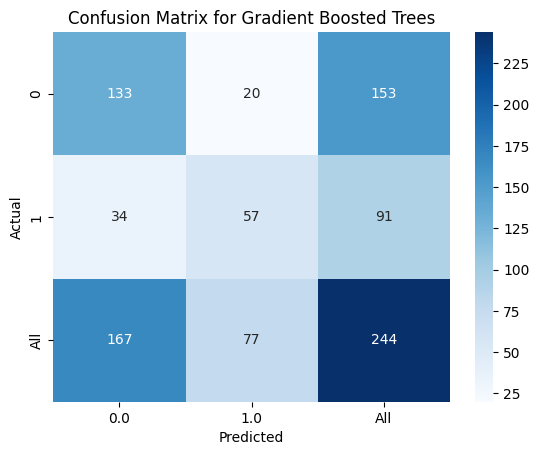

In [23]:
# Apply a classification model (Gradient Boosted Trees)
classifier_gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
model_gbt = classifier_gbt.fit(train_data)
show_predictions(model_gbt, train_data, "Training (Gradient Boosted Trees)")
show_predictions(model_gbt, test_data, "Testing (Gradient Boosted Trees)")
test_results_gbt = model_gbt.transform(test_data)
evaluate_model(test_results_gbt, "Gradient Boosted Trees")



Predictions on Training (Neural Network) Dataset:
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.6384842483061278,0.3615157516938723] |
|0    |0.0       |[0.8533134805498042,0.14668651945019595]|
|0    |0.0       |[0.8718403051560596,0.12815969484394038]|
|0    |0.0       |[0.88837248472815,0.11162751527185012]  |
|0    |0.0       |[0.9415437099671059,0.05845629003289409]|
|0    |0.0       |[0.9415437099671059,0.05845629003289409]|
|0    |0.0       |[0.9415437099671059,0.05845629003289409]|
|0    |0.0       |[0.8594833767707285,0.14051662322927141]|
|1    |0.0       |[0.887566329540093,0.11243367045990711] |
|0    |0.0       |[0.9363352168939606,0.06366478310603943]|
+-----+----------+----------------------------------------+
only showing top 10 rows


Predictions on Testing (Neural Network) Dataset:
+-----+----------+---------------

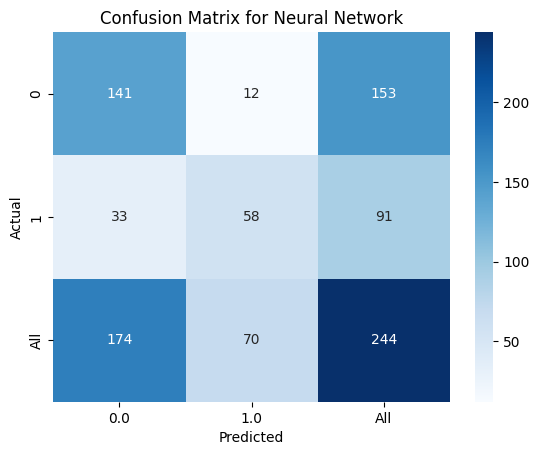

In [24]:
# Apply a classification model (Neural Network - Multilayer Perceptron)
# Define the layers for the neural network: input layer, hidden layers, and output layer
input_size = len(train_data.select("features").first()[0])  # Number of features
layers = [input_size, 10, 5, 2]  # Example: 10 neurons in the first hidden layer, 5 in the second, and 2 output classes
classifier_nn = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", maxIter=100, layers=layers, blockSize=128, seed=42)
model_nn = classifier_nn.fit(train_data)
show_predictions(model_nn, train_data, "Training (Neural Network)")
show_predictions(model_nn, test_data, "Testing (Neural Network)")
test_results_nn = model_nn.transform(test_data)
evaluate_model(test_results_nn, "Neural Network")

In [25]:
# Compare the models
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability")

print("\nModel Comparison:")
print(f"Random Forest: Accuracy={evaluator_multi.evaluate(test_results_rf, {evaluator_multi.metricName: 'accuracy'}):.2f}, AUC-ROC={evaluator_binary.evaluate(test_results_rf):.2f}")
print(f"Gradient Boosted Trees: Accuracy={evaluator_multi.evaluate(test_results_gbt, {evaluator_multi.metricName: 'accuracy'}):.2f}, AUC-ROC={evaluator_binary.evaluate(test_results_gbt):.2f}")
print(f"Neural Network: Accuracy={evaluator_multi.evaluate(test_results_nn, {evaluator_multi.metricName: 'accuracy'}):.2f}, AUC-ROC={evaluator_binary.evaluate(test_results_nn):.2f}")



Model Comparison:
Random Forest: Accuracy=0.81, AUC-ROC=0.85
Gradient Boosted Trees: Accuracy=0.78, AUC-ROC=0.80
Neural Network: Accuracy=0.82, AUC-ROC=0.84


In [26]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Define a function to evaluate the model and plot confusion matrix
def evaluate_model(test_results, model_name):
    evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    evaluator_binary = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability")

    accuracy = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "accuracy"})
    precision = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "weightedPrecision"})
    recall = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "weightedRecall"})
    f1 = evaluator_multi.evaluate(test_results, {evaluator_multi.metricName: "f1"})
    auc_roc = evaluator_binary.evaluate(test_results)

    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC-ROC: {auc_roc:.2f}")

    # Confusion Matrix
    y_true = test_results.select("label").toPandas()["label"].values
    y_pred = test_results.select("prediction").toPandas()["prediction"].values

    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

In [27]:
# Define a function to show predictions for training and testing datasets
def show_predictions(model, train_data, test_data, model_name):
    print(f"\n{model_name} Predictions for Training Data:")
    train_predictions = model.transform(train_data)
    train_predictions.select("features", "label", "prediction", "probability").show(5, truncate=False)

    print(f"\n{model_name} Predictions for Testing Data:")
    test_predictions = model.transform(test_data)
    test_predictions.select("features", "label", "prediction", "probability").show(5, truncate=False)



Neural Network Predictions for Training Data:
+-------------------------------------------------+-----+----------+----------------------------------------+
|features                                         |label|prediction|probability                             |
+-------------------------------------------------+-----+----------+----------------------------------------+
|(7,[0,1],[1.1980355400507012,2.290120200095667]) |0    |0.0       |[0.6384842483061278,0.3615157516938723] |
|(7,[0,1],[1.1980355400507012,2.9302071744294267])|0    |0.0       |[0.8533134805498042,0.14668651945019595]|
|(7,[0,1],[1.1980355400507012,3.0073178895459907])|0    |0.0       |[0.8718403051560596,0.12815969484394038]|
|(7,[0,1],[1.1980355400507012,3.0844286046625546])|0    |0.0       |[0.88837248472815,0.11162751527185012]  |
|(7,[0,1],[2.3960710801014025,2.290120200095667]) |0    |0.0       |[0.9415437099671059,0.05845629003289409]|
+-------------------------------------------------+-----+----------+-----

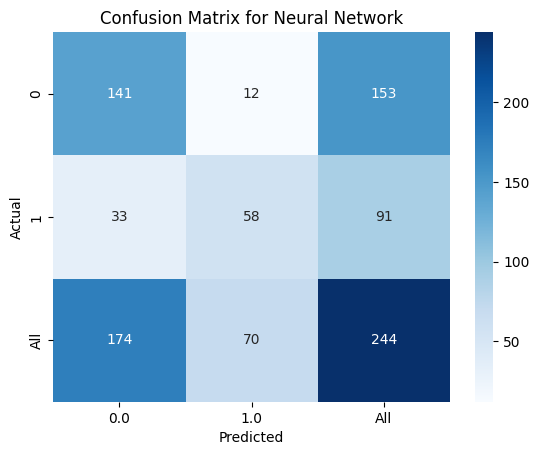


Model Comparison:
Random Forest - Accuracy: 0.81, Precision: 0.82, Recall: 0.81, F1-Score: 0.80, AUC-ROC: 0.85


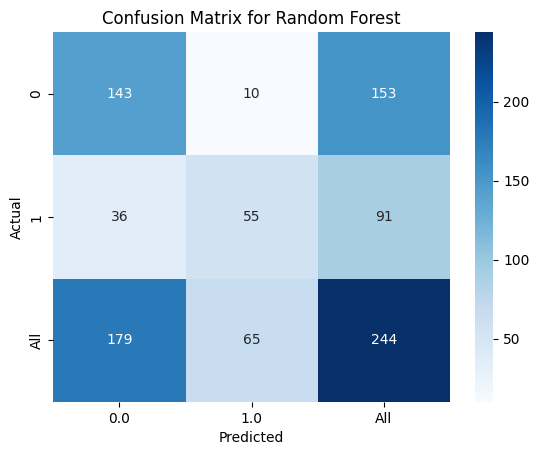

Gradient Boosted Trees - Accuracy: 0.78, Precision: 0.78, Recall: 0.78, F1-Score: 0.77, AUC-ROC: 0.80


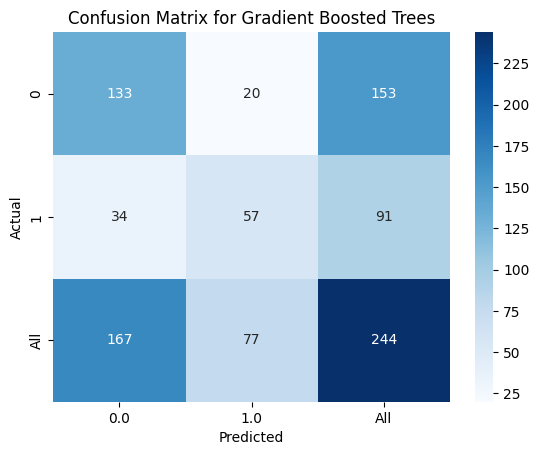

In [28]:
# Neural Network Classifier
input_size = len(train_data.select("features").first()[0])  # Number of features
layers = [input_size, 10, 5, 2]  # Example: 10 neurons in the first hidden layer, 5 in the second, and 2 output classes
classifier_nn = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", maxIter=100, layers=layers, blockSize=128, seed=42)
model_nn = classifier_nn.fit(train_data)

# Show predictions for Neural Network
show_predictions(model_nn, train_data, test_data, "Neural Network")

# Evaluate Neural Network
test_results_nn = model_nn.transform(test_data)
evaluate_model(test_results_nn, "Neural Network")

# Evaluate and Compare Models
print("\nModel Comparison:")

# Evaluate Random Forest
test_results_rf = model_rf.transform(test_data)
evaluate_model(test_results_rf, "Random Forest")

# Evaluate Gradient Boosted Trees
test_results_gbt = model_gbt.transform(test_data)
evaluate_model(test_results_gbt, "Gradient Boosted Trees")


In [29]:
def calculate_survival_rate(test_results, model_name):
    # Extract predictions
    survival_predictions = test_results.select("prediction").rdd.map(lambda row: row["prediction"]).collect()
    
    # Calculate survival rate
    total_count = len(survival_predictions)
    survival_count = sum(1 for pred in survival_predictions if pred == 1.0)
    survival_rate = survival_count / total_count * 100  # Convert to percentage

    print(f"{model_name} Predicted Survival Rate: {survival_rate:.2f}% ({survival_count}/{total_count} predicted to survive)")

In [30]:
calculate_survival_rate(test_results_rf, "Random Forest")
calculate_survival_rate(test_results_gbt, "Gradient Boosted Trees")
calculate_survival_rate(test_results_nn, "Neural Network")

Random Forest Predicted Survival Rate: 26.64% (65/244 predicted to survive)
Gradient Boosted Trees Predicted Survival Rate: 31.56% (77/244 predicted to survive)
Neural Network Predicted Survival Rate: 28.69% (70/244 predicted to survive)


Random Forest Predicted Survival Rate: 26.64% (65/244 predicted to survive)


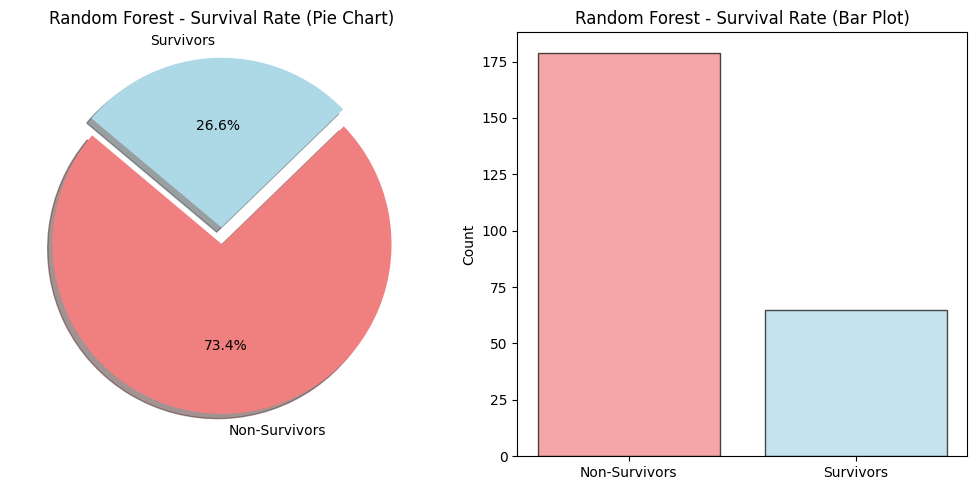

Gradient Boosted Trees Predicted Survival Rate: 31.56% (77/244 predicted to survive)


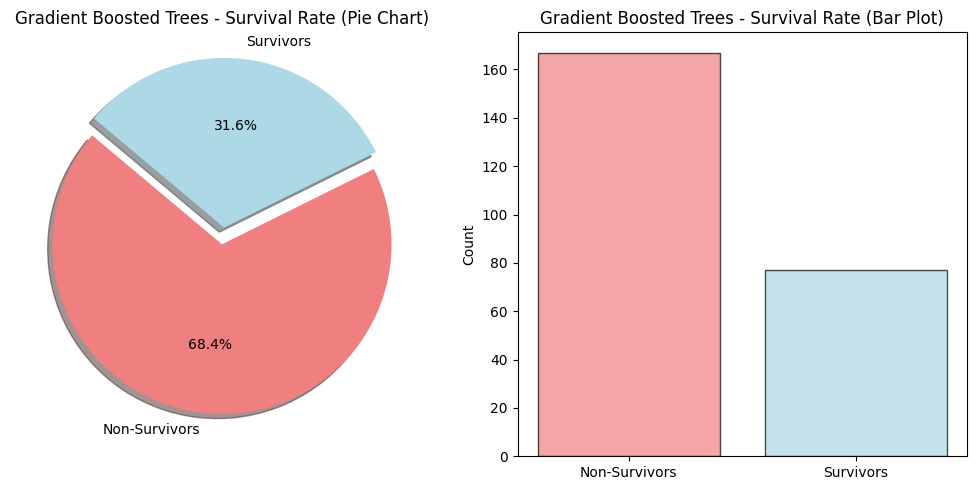

Neural Network Predicted Survival Rate: 28.69% (70/244 predicted to survive)


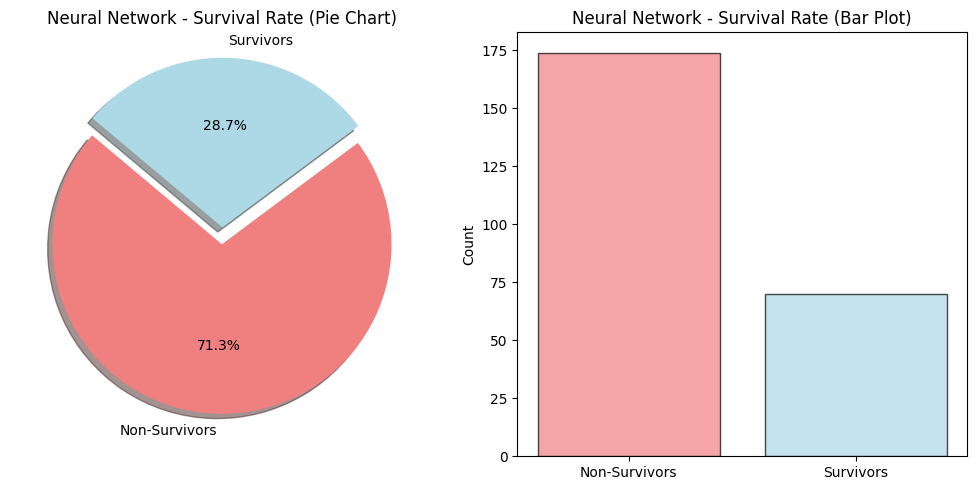

In [31]:
def visualize_survival_rate(test_results, model_name):
    # Extract predictions
    survival_predictions = test_results.select("prediction").rdd.map(lambda row: row["prediction"]).collect()

    # Calculate counts
    total_count = len(survival_predictions)
    survival_count = sum(1 for pred in survival_predictions if pred == 1.0)
    non_survival_count = total_count - survival_count
    survival_rate = survival_count / total_count * 100  # Convert to percentage

    # Print survival rate
    print(f"{model_name} Predicted Survival Rate: {survival_rate:.2f}% ({survival_count}/{total_count} predicted to survive)")

    # Create a pie chart
    labels = ['Non-Survivors', 'Survivors']
    sizes = [non_survival_count, survival_count]
    colors = ['lightcoral', 'lightblue']
    explode = (0, 0.1)  # Highlight the "Survivors" slice

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title(f"{model_name} - Survival Rate (Pie Chart)")

    # Create a bar plot
    plt.subplot(1, 2, 2)
    plt.bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
    plt.title(f"{model_name} - Survival Rate (Bar Plot)")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()


# Call the function for each model
visualize_survival_rate(test_results_rf, "Random Forest")
visualize_survival_rate(test_results_gbt, "Gradient Boosted Trees")
visualize_survival_rate(test_results_nn, "Neural Network")

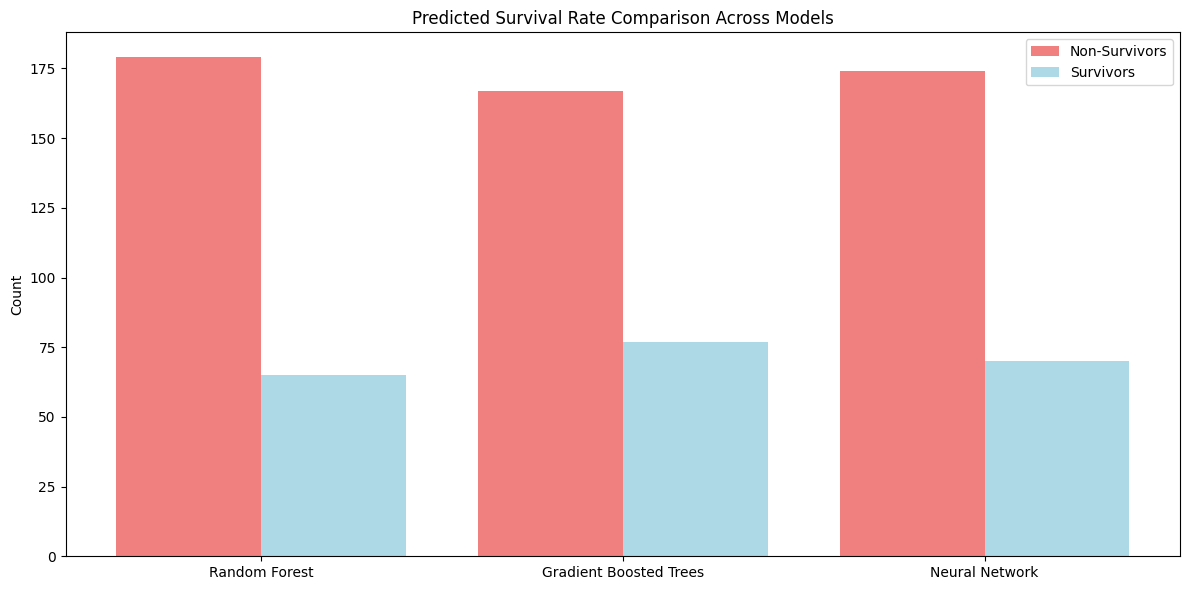

In [32]:
def compare_model_survival_rates(results_list, model_names):
    # Prepare data
    survivor_counts = []
    non_survivor_counts = []
    for test_results in results_list:
        survival_predictions = test_results.select("prediction").rdd.map(lambda row: row["prediction"]).collect()
        survivor_counts.append(sum(1 for pred in survival_predictions if pred == 1.0))
        non_survivor_counts.append(len(survival_predictions) - survivor_counts[-1])

    # Bar Plot: Compare models
    x = np.arange(len(model_names))
    bar_width = 0.4

    plt.figure(figsize=(12, 6))
    plt.bar(x - bar_width / 2, non_survivor_counts, bar_width, label='Non-Survivors', color='lightcoral')
    plt.bar(x + bar_width / 2, survivor_counts, bar_width, label='Survivors', color='lightblue')
    
    plt.xticks(x, model_names)
    plt.ylabel('Count')
    plt.title('Predicted Survival Rate Comparison Across Models')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Call the function to compare
compare_model_survival_rates(
    [test_results_rf, test_results_gbt, test_results_nn],
    ["Random Forest", "Gradient Boosted Trees", "Neural Network"]
)
